In [1]:
from __future__ import print_function

import argparse
import csv
import os
import sys
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import glob
import pickle

import datetime
import math
import json
import time

import timm
from timm.models import create_model
from timm.scheduler import CosineLRScheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict
from sklearn.metrics import roc_auc_score

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

from customloss import CustomLoss
from datamgr import *
import utils
from engine import *
from dataset import *
from samplers import RASampler

import copy
from pathlib import Path
from tqdm import tqdm

def save_pickle(file, data):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

        
def load_pickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [2]:
CNN_output_dir = Path('./checkpoints/CBNA/CNN/')
MLP_output_dir = Path('./checkpoints/CBNA/MLP/')

train_targets = torch.load(CNN_output_dir.joinpath('CNN_train_predictions.pth'))['targets']
CNN_train_preds = torch.load(CNN_output_dir.joinpath('CNN_train_predictions.pth'))['predictions']
MLP_train_preds = torch.load(MLP_output_dir.joinpath('MLP_train_predictions.pth'))['predictions']

test_targets = torch.load(CNN_output_dir.joinpath('CNN_test_predictions.pth'))['targets']
CNN_test_preds = torch.load(CNN_output_dir.joinpath('CNN_test_predictions.pth'))['predictions']
MLP_test_preds = torch.load(MLP_output_dir.joinpath('MLP_test_predictions.pth'))['predictions']

In [3]:
from sklearn.isotonic import IsotonicRegression

In [5]:
CNN_iso = IsotonicRegression(out_of_bounds = 'clip')
CNN_calib_test_preds = []

for idx in range(train_targets.shape[1]):
    CNN_iso.fit(CNN_train_preds[:,idx], train_targets[:,idx])
    CNN_calib_test_probs = CNN_iso.predict(CNN_test_preds[:,idx])
    CNN_calib_test_preds.append(torch.tensor(CNN_calib_test_probs).unsqueeze(0))

CNN_calib_test_preds = torch.cat(CNN_calib_test_preds).t()

In [13]:
def compute_scores(outputs, targets, threshold=0.45):
    
    prob = outputs >= threshold
    label = targets >= threshold
    TP = (prob & label).sum(0).float()
    TN = ((~prob) & (~label)).sum(0).float()
    FP = (prob & (~label)).sum(0).float()
    FN = ((~prob) & label).sum(0).float()
    
    # macro true skill score
    macro_recall = TP / (TP + FN + 1e-8)
    macro_specificity = TN / (TN + FP + 1e-8)
    macro_tss = torch.mean(macro_recall + macro_specificity - 1)
    macro_precision = TP / (TP + FP + 1e-8)
    macro_accuracy = (TP + TN) / (TP + FP + TN + FN + 1e-8)
    print('macro recall: ', torch.mean(macro_recall).item())
    print('macro specificity: ', torch.mean(macro_specificity).item())
    print('macro tss: ', torch.mean(macro_tss).item())
    print('macro precision: ', torch.mean(macro_precision).item())
    print('macro_accuracy: ', torch.mean(macro_accuracy).item())
    # micro true skill score
    micro_recall = TP.sum() / (TP.sum() + FN.sum())
    micro_specificity = TN.sum() / (TN.sum() + FP.sum())
    micro_tss = micro_recall + micro_specificity - 1
    micro_precision = TP.sum() / (TP.sum() + FP.sum() + 1e-8)
    micro_accuracy = (TP.sum() + TN.sum()) / (TP.sum() + FP.sum() + TN.sum() + FN.sum() + 1e-8)
    print('micro recall: ', micro_recall.item())
    print('micro specificity: ', torch.mean(micro_specificity).item())
    print('micro tss: ', torch.mean(micro_tss).item())
    print('micro_precision: ', micro_precision.item())
    print('micro_accuracy: ', micro_accuracy.item())
    

In [14]:
compute_scores(CNN_calib_test_preds, test_targets, threshold=0.01)

macro recall:  0.6793069839477539
macro specificity:  0.8866408467292786
macro tss:  0.5659478306770325
macro precision:  0.040565989911556244
macro_accuracy:  0.8882507681846619
micro recall:  0.8912724256515503
micro specificity:  0.888227105140686
micro tss:  0.7794995307922363
micro_precision:  0.058801889419555664
micro_accuracy:  0.8882507681846619


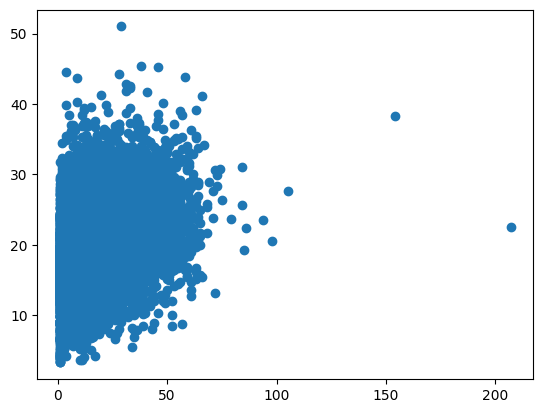

In [11]:
plt.scatter(test_targets.sum(1), CNN_calib_test_preds.sum(1))

In [15]:
MLP_iso = IsotonicRegression(out_of_bounds = 'clip')
MLP_calib_test_preds = []

for idx in range(train_targets.shape[1]):
    MLP_iso.fit(MLP_train_preds[:,idx], train_targets[:,idx])
    MLP_calib_test_probs = MLP_iso.predict(MLP_test_preds[:,idx])
    MLP_calib_test_preds.append(torch.tensor(MLP_calib_test_probs).unsqueeze(0))

MLP_calib_test_preds = torch.cat(MLP_calib_test_preds).t()

In [16]:
compute_scores(MLP_calib_test_preds, test_targets, threshold=0.01)

macro recall:  0.6846301555633545
macro specificity:  0.8679312467575073
macro tss:  0.5525612831115723
macro precision:  0.037342529743909836
macro_accuracy:  0.8700000643730164
micro recall:  0.9011030793190002
micro specificity:  0.8697562217712402
micro tss:  0.7708592414855957
micro_precision:  0.05141952261328697
micro_accuracy:  0.8699999451637268


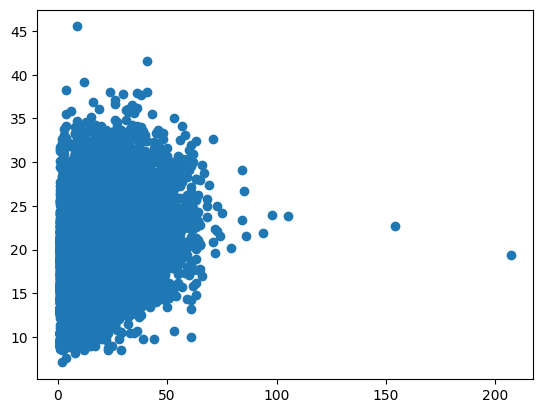

In [17]:
plt.scatter(test_targets.sum(1), MLP_calib_test_preds.sum(1))